<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_13_04_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 13: Advanced/Other Topics**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 13 Video Material

* Part 13.1: Flask and Deep Learning Web Services [[Video]](https://www.youtube.com/watch?v=H73m9XvKHug&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_13_01_flask.ipynb)
* Part 13.2: Interrupting and Continuing Training  [[Video]](https://www.youtube.com/watch?v=kaQCdv46OBA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_13_02_checkpoint.ipynb)
* Part 13.3: Using a Keras Deep Neural Network with a Web Application  [[Video]](https://www.youtube.com/watch?v=OBbw0e-UroI&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_13_03_web.ipynb)
* **Part 13.4: When to Retrain Your Neural Network** [[Video]](https://www.youtube.com/watch?v=K2Tjdx_1v9g&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_13_04_retrain.ipynb)
* Part 13.5: Tensor Processing Units (TPUs)  [[Video]](https://www.youtube.com/watch?v=Ygyf3NUqvSc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_13_05_tpu.ipynb)



# Part 13.4: When to Retrain Your Neural Network

Dataset drift is a problem frequently seen in real-world applications of machine learning. Academic problems that courses typically present in school assignments usually do not experience this problem. For a class assignment, your instructor provides a single data set representing all of the data you will ever see for a task. In the real world, you obtain initial data to train your model; then, you will acquire new data over time that you use your model to predict.

Consider this example. You create a startup company that develops a mobile application that helps people find jobs. To train your machine learning model, you collect attributes about people and their careers. Once you have your data, you can prepare your neural network to suggest the best jobs for individuals. 

Once your application is released, you will hopefully obtain new data. This data will come from job seekers using your app. These people are your customers. You have x values (their attributes), but you do not have y-values (their jobs). Your customers have come to you to find out what their be jobs will be. You will provide the customer's attributes to the neural network, and then it will predict their jobs. Usually, companies develop neural networks on initial data and then use the neural network to perform predictions on new data obtained over time from their customers.

Your job prediction model will become less relevant as the industry introduces new job types and the demographics of your customers change. However, companies must look if their model is still relevant as time passes. This change in your underlying data is called dataset drift. In this section, we will see ways that you can measure dataset drift.

You can present your model with new data and see how its accuracy changes over time. However, to calculate efficiency, you must know the expected outputs from the model (y-values). You may not know the correct outcomes for new data that you are obtaining in real-time. Therefore, we will look at algorithms that examine the x-inputs and determine how much they have changed in distribution from the original x-inputs that we trained on. These changes are called dataset drift.

Let's begin by creating generated data that illustrates drift. We present the following code to create a chart that shows such drift.

-1.279075878908335
1.0273360721736102


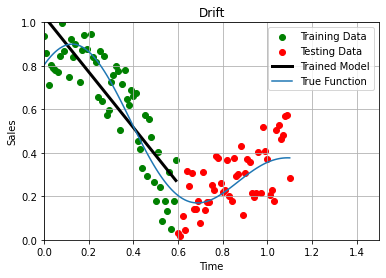

In [1]:
import numpy as np

import matplotlib.pyplot as plot
from sklearn.linear_model import LinearRegression

def true_function(x):
    x2 = (x*8) - 1
    return ((np.sin(x2)/x2)*0.6)+0.3
    
#
x_train  = np.arange(0, 0.6, 0.01)
x_test  = np.arange(0.6, 1.1, 0.01)
x_true = np.concatenate( (x_train, x_test) )

#
y_true_train = true_function(x_train)
y_true_test = true_function(x_test)
y_true   = np.concatenate( (y_true_train, y_true_test) )

#
y_train = y_true_train + (np.random.rand(*x_train.shape)-0.5)*0.4
y_test  = y_true_test + (np.random.rand(*x_test.shape)-0.5)*0.4

#
lr_x_train = x_train.reshape((x_train.shape[0],1))
reg = LinearRegression().fit(lr_x_train, y_train)
reg_pred = reg.predict(lr_x_train)
print(reg.coef_[0])
print(reg.intercept_)

#
plot.xlim([0,1.5])
plot.ylim([0,1])
l1 = plot.scatter(x_train, y_train, c="g", label="Training Data")
l2 = plot.scatter(x_test, y_test, c="r", label="Testing Data")
l3, = plot.plot(lr_x_train, reg_pred, color='black', linewidth=3, 
                label="Trained Model")
l4, = plot.plot(x_true, y_true, label = "True Function")
plot.legend(handles=[l1, l2, l3, l4])

#
plot.title('Drift')
plot.xlabel('Time')
plot.ylabel('Sales')
plot.grid(True, which='both')
plot.show()

The "True function" represents what the data does over time. Unfortunately, you only have the training portion of the data. Your model will do quite well on the data that you trained it with; however, it will be very inaccurate on the new test data presented. The prediction line for the model fits the training data well but does not fit the est data well.

## Preprocessing the Sberbank Russian Housing Market Data

The examples provided in this section use a Kaggle dataset named The Sberbank Russian Housing Market, which you can access from the following link.

* [Sberbank Russian Housing Market](https://www.kaggle.com/c/sberbank-russian-housing-market/data)

Because Kaggle provides datasets as training and test, we must load both of these files.

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

PATH = "/data/ml_learning/sberbank-russian-housing-market"


train_df = pd.read_csv(os.path.join(PATH,"train.csv"))
test_df = pd.read_csv(os.path.join(PATH,"test.csv"))

I provide a simple preprocess function that converts all numerics to z-scores and all categoricals to dummies.

In [3]:
def preprocess(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            df[i] = df[i].fillna(df[i].mode().iloc[0])
        elif (df[i].dtype == 'int' or df[i].dtype == 'float'):
            df[i] = df[i].fillna(np.nanmedian(df[i]))

    enc = LabelEncoder()
    for i in df.columns:
        if (df[i].dtype == 'object'):
            df[i] = enc.fit_transform(df[i].astype('str'))
            df[i] = df[i].astype('object')

Next, we run the training and test datasets through the preprocessing function.

In [4]:
preprocess(train_df)
preprocess(test_df)

Finally, we remove thr target variable.  We are only looking for drift on the $x$ (input data).

In [5]:
train_df.drop('price_doc',axis=1,inplace=True)

## KS-Statistic

We will use the KS-Statistic to determine the difference in distribution between columns in the training and test sets. As a baseline, consider if we compare the same field to itself. In this case, we are comparing the **kitch_sq** in the training set. Because there is no difference in distribution between a field in itself, the p-value is 1.0, and the KS-Statistic statistic is 0. The P-Value is the probability of no difference between the two distributions. Typically some lower threshold is used for how low a P-Value is needed to reject the null hypothesis and assume there is a difference. The value of 0.05 is a standard threshold for p-values. Because the p-value is NOT below 0.05, we expect the two distributions to be the same. If the p-value were below the threshold, the **statistic** value becomes interesting. T**his value tells you how different the two distributions are. A value of 0.0, in this case, means no differences.**

In [6]:
from scipy import stats

stats.ks_2samp(train_df['kitch_sq'], train_df['kitch_sq'])

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.0, statistic_sign=1)

Now let's do something more interesting.  We will compare the same field **kitch_sq** between the test and training sets.  In this case, the p-value is below 0.05, so the **statistic** value now contains the amount of difference detected.

In [7]:
stats.ks_2samp(train_df['kitch_sq'], test_df['kitch_sq'])

KstestResult(statistic=0.25829078867676714, pvalue=0.0, statistic_location=6.0, statistic_sign=1)

Next, we pull the KS-Stat for every field.  We also establish a boundary for the maximum p-value and how much of a difference is needed before we display the column.

In [8]:
for col in train_df.columns:
    ks = stats.ks_2samp(train_df[col], test_df[col])
    if ks.pvalue < 0.05 and ks.statistic>0.1:
        print(f'{col}: {ks}')

id: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=30473, statistic_sign=1)
timestamp: KstestResult(statistic=0.8982081426022823, pvalue=0.0, statistic_location=268, statistic_sign=-1)
life_sq: KstestResult(statistic=0.2255084471628891, pvalue=4.856705292020823e-274, statistic_location=30.0, statistic_sign=1)
max_floor: KstestResult(statistic=0.17313454154786817, pvalue=6.0543428287186905e-161, statistic_location=12.0, statistic_sign=1)
build_year: KstestResult(statistic=0.3176883950430345, pvalue=0.0, statistic_location=1979.0, statistic_sign=1)
num_room: KstestResult(statistic=0.1226755470309048, pvalue=9.415711716396215e-81, statistic_location=1.0, statistic_sign=-1)
kitch_sq: KstestResult(statistic=0.25829078867676714, pvalue=0.0, statistic_location=6.0, statistic_sign=1)
state: KstestResult(statistic=0.13641341252952505, pvalue=7.948160025025859e-100, statistic_location=1.0, statistic_sign=-1)
preschool_quota: KstestResult(statistic=0.2364160801236304, pvalue=1.6891462

raion_build_count_with_material_info: KstestResult(statistic=0.19083554469945835, pvalue=9.999734275110374e-196, statistic_location=273.0, statistic_sign=1)
build_count_block: KstestResult(statistic=0.2085099875571384, pvalue=5.963760498964035e-234, statistic_location=42.0, statistic_sign=1)
build_count_wood: KstestResult(statistic=0.20880892257287548, pvalue=1.2554166698789668e-234, statistic_location=0.0, statistic_sign=1)
build_count_brick: KstestResult(statistic=0.20707302040295733, pvalue=1.033868081305525e-230, statistic_location=73.0, statistic_sign=1)
build_count_monolith: KstestResult(statistic=0.1779053203005685, pvalue=5.6302768781495314e-170, statistic_location=6.0, statistic_sign=1)
raion_build_count_with_builddate_info: KstestResult(statistic=0.19083554469945835, pvalue=9.999734275110374e-196, statistic_location=271.0, statistic_sign=1)
build_count_1946-1970: KstestResult(statistic=0.2120848849003817, pvalue=4.134986862232885e-242, statistic_location=135.0, statistic_sign

## Detecting Drift between Training and Testing Datasets by Training

Sample the training and test into smaller sets to train.  We want 10K elements from each; however, the test set only has 7,662, so we only sample that amount from each side.

In [9]:
SAMPLE_SIZE = min(len(train_df),len(test_df))
SAMPLE_SIZE = min(SAMPLE_SIZE,10000)
print(SAMPLE_SIZE)

7662


We take the random samples from the training and test sets and add a flag called **source_training** to tell the two apart.

In [10]:
training_sample = train_df.sample(SAMPLE_SIZE, random_state=49)
testing_sample = test_df.sample(SAMPLE_SIZE, random_state=48)

# Is the data from the training set?
training_sample['source_training'] = 1
testing_sample['source_training'] = 0

Next, we combine the data that we sampled from the training and test data sets and shuffle them.

In [11]:
# Build combined training set
combined = testing_sample.append(training_sample)
combined.reset_index(inplace=True, drop=True)

# Now randomize
combined = combined.reindex(np.random.permutation(combined.index))
combined.reset_index(inplace=True, drop=True)

<ipython-input-11-5bfd25307fe6>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = testing_sample.append(training_sample)


We will now generate $x$ and $y$ to train.  We attempt to predict the **source_training** value as $y$, which indicates if the data came from the training or test set.  **If the model successfully uses the data to predict if it came from training or testing, then there is likely drift.**  Ideally, the train and test data should be indistinguishable.  

In [12]:
# Get ready to train
y = combined['source_training'].values
combined.drop('source_training',axis=1,inplace=True)
x = combined.values

y

array([1, 1, 0, ..., 1, 0, 1])

We will consider anything above a 0.75 AUC as having a good chance of drift.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators = 60, max_depth = 7,
    min_samples_leaf = 5)
lst = []

for i in combined.columns:
    score = cross_val_score(model,pd.DataFrame(combined[i]),y,cv=2,
                            scoring='roc_auc')
    if (np.mean(score) > 0.75): # print out anything above a 0.75 AUC
        lst.append(i)
        print(i,np.mean(score))

id 1.0
timestamp 0.9602954670375439
full_sq 0.824525207233493
life_sq 0.8721326474233304
build_year 0.8011759362428296
kitch_sq 0.9071337795005247
cafe_sum_500_min_price_avg 0.8427447002059951
cafe_avg_price_500 0.8444792175769242
